<a href="https://colab.research.google.com/github/PCsujan/DataWarehouseDataMining/blob/main/DatawarehouseLab_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

def k_means(data, k, max_iters=100):
    data = data.to_numpy()
    n = data.shape[0]
    centroids = data[np.random.choice(n, k, replace=False)]

    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        for point in data:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(point)

        new_centroids = np.array([np.mean(cluster, axis=0) if cluster else centroids[i]
                                  for i, cluster in enumerate(clusters)])

        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    return centroids, clusters

# Usage
# centroids, clusters = k_means_pp(df, k=3)

In [3]:
def k_means_pp(data, k, max_iters=100):
    data = data.to_numpy()
    n = data.shape[0]
    centroids = [data[np.random.randint(n)]]

    for _ in range(1, k):
        dists = np.array([min(np.linalg.norm(x - c)**2 for c in centroids) for x in data])
        probs = dists / dists.sum()
        next_centroid = data[np.random.choice(n, p=probs)]
        centroids.append(next_centroid)

    centroids = np.array(centroids)

    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        for point in data:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            clusters[np.argmin(distances)].append(point)
        new_centroids = np.array([np.mean(c, axis=0) if c else centroids[i]
                                  for i, c in enumerate(clusters)])
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    return centroids, clusters

# Usage
# medoids, clusters = k_medoids(df, k=3)

In [4]:
def k_medoids(data, k, max_iters=100):
    data = data.to_numpy()
    n = len(data)
    medoids = data[np.random.choice(n, k, replace=False)]

    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        for point in data:
            distances = [np.linalg.norm(point - medoid) for medoid in medoids]
            clusters[np.argmin(distances)].append(point)

        new_medoids = []
        for cluster in clusters:
            if not cluster:
                new_medoids.append(medoids[len(new_medoids)])
                continue
            dists = [[np.linalg.norm(p1 - p2) for p2 in cluster] for p1 in cluster]
            total_dists = [sum(row) for row in dists]
            new_medoids.append(cluster[np.argmin(total_dists)])

        if np.allclose(medoids, new_medoids):
            break
        medoids = np.array(new_medoids)

    return medoids, clusters

# Usage
# clusters = agglomerative_clustering(df, k=3)


In [5]:
def agglomerative_clustering(data, k):
    from scipy.spatial.distance import cdist

    data = data.to_numpy()
    clusters = [[i] for i in range(len(data))]

    while len(clusters) > k:
        dists = cdist([data[i[0]] for i in clusters], [data[i[0]] for i in clusters])
        np.fill_diagonal(dists, np.inf)
        i, j = np.unravel_index(np.argmin(dists), dists.shape)
        clusters[i] += clusters[j]
        del clusters[j]

    return [[data[i] for i in cluster] for cluster in clusters]

/tmp/ipython-input-6-903884531.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


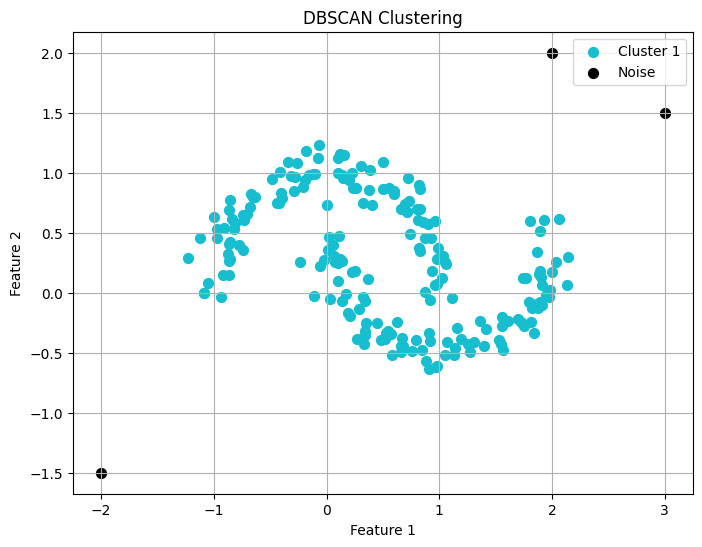

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque


def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def region_query(data, point_idx, eps):
    neighbors = []
    for i, point in enumerate(data):
        if euclidean_distance(point, data[point_idx]) < eps:
            neighbors.append(i)
    return neighbors

def expand_cluster(data, labels, point_idx, cluster_id, eps, min_pts):
    seeds = region_query(data, point_idx, eps)
    if len(seeds) < min_pts:
        labels[point_idx] = -1  # Noise
        return False
    else:
        labels[point_idx] = cluster_id
        queue = deque(seeds)
        while queue:
            current_point = queue.popleft()
            if labels[current_point] == -1:
                labels[current_point] = cluster_id
            elif labels[current_point] == 0:
                labels[current_point] = cluster_id
                result = region_query(data, current_point, eps)
                if len(result) >= min_pts:
                    queue.extend(result)
        return True

def dbscan(data, eps, min_pts):
    n = len(data)
    labels = [0] * n
    cluster_id = 0
    for i in range(n):
        if labels[i] == 0:
            if expand_cluster(data, labels, i, cluster_id + 1, eps, min_pts):
                cluster_id += 1
    return np.array(labels)


df = pd.read_csv("/content/sample_data/data2.csv")
X = df[["Feature_1", "Feature_2"]].values

eps = 0.5     # distance threshold
min_pts = 4   # minimum number of neighbors

labels = dbscan(X, eps=eps, min_pts=min_pts)


def plot_dbscan(X, labels):
    unique_labels = set(labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    plt.figure(figsize=(8, 6))
    for label in unique_labels:
        cluster_points = X[labels == label]
        color = 'k' if label == -1 else colors(label % 10)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    color=color, label=f"Cluster {label}" if label != -1 else "Noise", s=50)

    plt.title("DBSCAN Clustering")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_dbscan(X, labels)

Number of outliers: 0


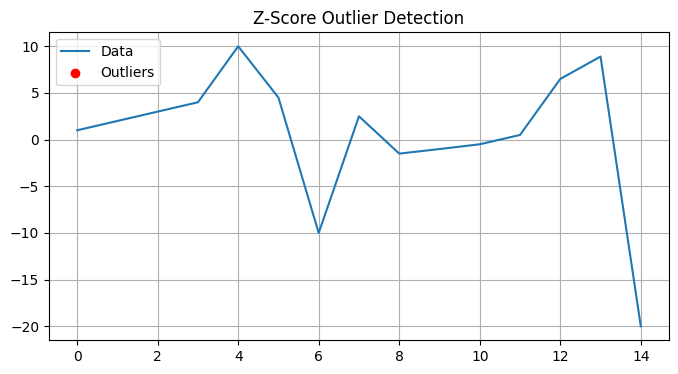

In [7]:
def z_score_outliers(data, threshold=3):
    values = data["Value"]
    mean = values.mean()
    std = values.std()
    z_scores = (values - mean) / std
    return data[np.abs(z_scores) > threshold]

# visualization
df_out = pd.read_csv("/content/sample_data/data3.csv")
outliers = z_score_outliers(df_out)

print(f"Number of outliers: {len(outliers)}")

def plot_z_score_outliers(df):
    import matplotlib.pyplot as plt
    values = df["Value"]
    z_outliers = z_score_outliers(df)
    plt.figure(figsize=(8, 4))
    plt.plot(values, label='Data')
    plt.scatter(z_outliers.index, z_outliers["Value"], color='red', label='Outliers')
    plt.title("Z-Score Outlier Detection")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_z_score_outliers(df_out)

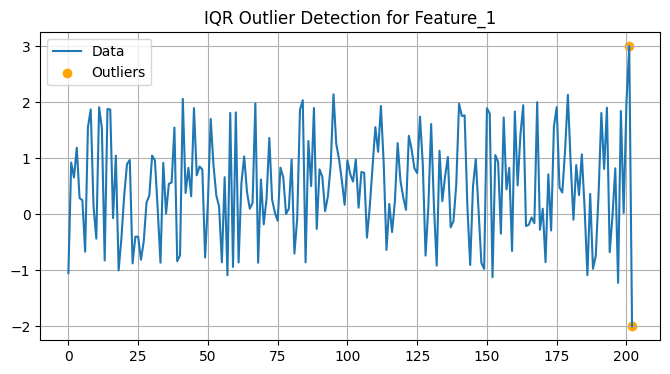

In [9]:
def iqr_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

def plot_iqr_outliers(data, column):
    import matplotlib.pyplot as plt
    values = data[column]
    iqr_out = iqr_outliers(data, column)
    plt.figure(figsize=(8, 4))
    plt.plot(values.values, label='Data')
    plt.scatter(iqr_out.index, iqr_out[column], color='orange', label='Outliers')
    plt.title(f"IQR Outlier Detection for {column}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
plot_iqr_outliers(df, 'Feature_1')


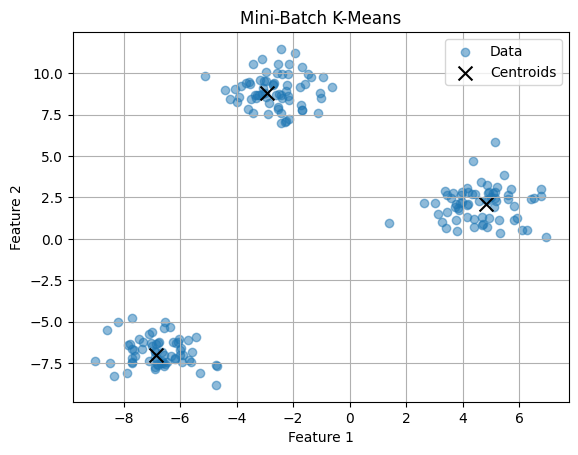

In [10]:
def mini_batch_k_means(data, k, batch_size=5, max_iters=100):
    data = data.to_numpy()
    n = data.shape[0]
    centroids = data[np.random.choice(n, k, replace=False)]

    for _ in range(max_iters):
        batch = data[np.random.choice(n, batch_size, replace=False)]
        for point in batch:
            i = np.argmin([np.linalg.norm(point - c) for c in centroids])
            centroids[i] = centroids[i] + 0.1 * (point - centroids[i])  # Update step

    return centroids


df_k = pd.read_csv("/content/sample_data/data4.csv")

def plot_mini_batch(df, centroids, title="Mini-Batch K-Means"):
    import matplotlib.pyplot as plt
    X = df.to_numpy()
    plt.scatter(X[:, 0], X[:, 1], label='Data', alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

centroids = mini_batch_k_means(df_k, k=3)
plot_mini_batch(df_k, centroids)

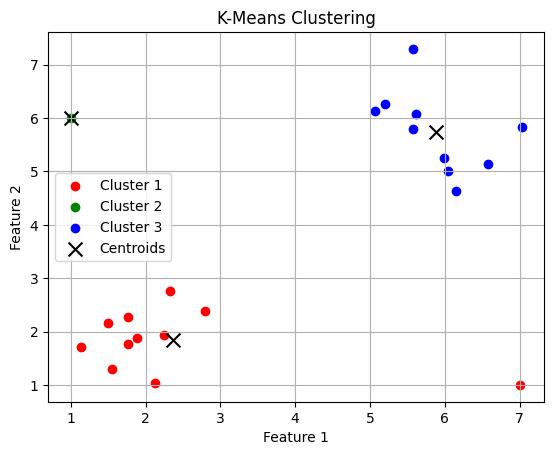

In [11]:
def plot_clusters(clusters, centroids, title):
    import matplotlib.pyplot as plt
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for idx, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[idx % len(colors)], label=f'Cluster {idx+1}')
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# visualization for  k_means:
df = pd.read_csv("/content/sample_data/data.csv")
centroids, clusters = k_means(df, k=3)
plot_clusters(clusters, centroids, "K-Means Clustering")

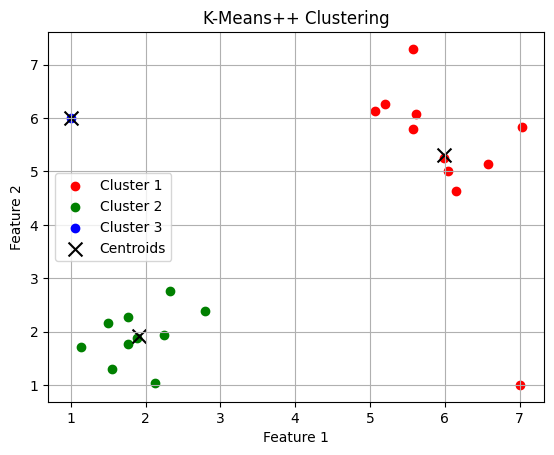

In [12]:
# visualization for k_means_pp:
centroids, clusters = k_means_pp(df, k=3)
plot_clusters(clusters, centroids, "K-Means++ Clustering")

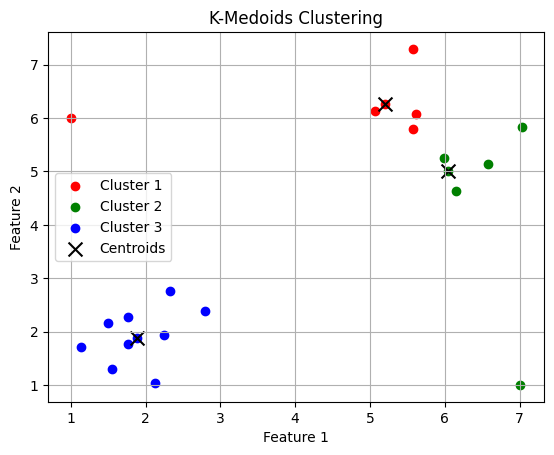

In [13]:
# k_medoids:
medoids, clusters = k_medoids(df, k=3)
plot_clusters(clusters, medoids, "K-Medoids Clustering")

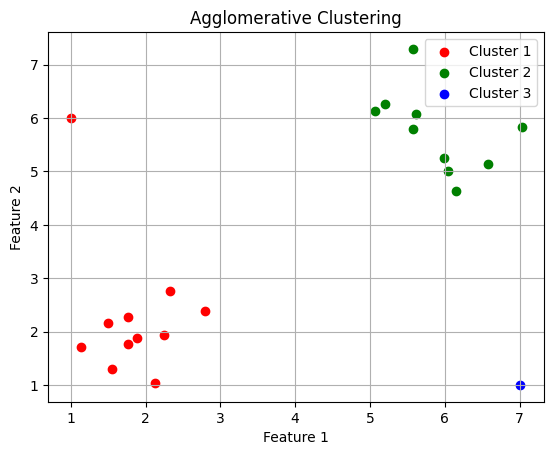

In [14]:
def plot_agglomerative(clusters, title):
    import matplotlib.pyplot as plt
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    for idx, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[idx % len(colors)], label=f'Cluster {idx+1}')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# visulization:
clusters = agglomerative_clustering(df, k=3)
plot_agglomerative(clusters, "Agglomerative Clustering")
